# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import Counter
import copy

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.cm as cm
import itertools

In [3]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
TONE_TIMESTAMP_DF = pd.read_pickle("./proc/trial_metadata.pkl")
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("../../data/video_to_frame_and_subject.xlsx")
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/proc/id_corrected"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22
VELOCITY_WINDOW_SIZE = FRAME_RATE
ROLLING_AVERAGE_WINDOW_SIZE = FRAME_RATE // 2
TRIAL_DURATION = 10

In [5]:
SPIKEGADGETS_SAMPLE_RATE = 20000
LFP_SAMPLE_RATE = 1000
VELOCITY_BINS = [2.5, 5, 10]
DISTANCE_BINS = [5]

In [6]:
outcome_to_color = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}

In [7]:
trial_or_baseline_to_style = {'trial': "-",
 'baseline': "--"}

In [8]:
TONE_TIMESTAMP_DF["recording_file"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
       '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
       '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [9]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names


In [10]:
def get_sleap_tracks_from_h5(filename):
    """
    Retrieve pose tracking data (tracks) from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    np.ndarray
        A transposed version of the 'tracks' dataset in the provided h5 file.
        
    Example:
    --------
    df['tracks'] = df['filename_column'].apply(get_sleap_tracks_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return f["tracks"][:].T

In [11]:
def get_sleap_track_names_from_h5(filename):
    """
    Retrieve the names of tracked features from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    h5py.Dataset
        The 'track_names' dataset in the provided h5 file, representing the names of the tracked features.
        
    Example:
    --------
    df['track_names'] = df['filename_column'].apply(get_sleap_track_names_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return [item.tobytes().decode('utf-8') for item in f["track_names"][:]]


In [12]:
def get_node_names_from_sleap(filename):
    """
    Retrieve node names from a SLEAP h5 file.

    Parameters:
    - filename (str): Path to the SLEAP h5 file.

    Returns:
    - list of str: List of node names.
    """
    with h5py.File(filename, "r") as f:
        return [n.decode() for n in f["node_names"][:]]

In [13]:

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [14]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [15]:
def extract_sleap_data(filename):
    """
    Extracts coordinates, names of body parts, and track names from a SLEAP file.
    
    Parameters:
    - filename (str): Path to the SLEAP file.
    
    Returns:
    - tuple: A tuple containing the following elements:
        * location (numpy.ndarray): Array containing the coordinates.
        * node_names (list of str): List of body part names.
        * track_names (list of str): List of track names.
    
    Example:
    >>> location, node_names, track_names = extract_sleap_data("path/to/sleap/file.h5")
    """
    result = {}
    with h5py.File(filename, "r") as f:
        result["location"] = f["tracks"][:].T
        result["node_names"] = [n.decode() for n in f["node_names"][:]]
        result["track_names"] = [n.decode() for n in f["track_names"][:]]

    return result

In [16]:
def rescale_dimension_in_array(arr, dimension=0, ratio=1):
    """
    Rescale values of a specified dimension in a 3D numpy array for the entire array.
    
    Parameters:
    - arr (numpy.ndarray): A 3D numpy array where the third dimension is being rescaled.
    - dimension (int, default=0): Specifies which dimension (0 or 1) of the third 
                                  dimension in the array should be rescaled. 
                                  For instance, in many contexts:
                                  0 represents the x-coordinate, 
                                  1 represents the y-coordinate.
    - ratio (float, default=1): The scaling factor to be applied.
    
    Returns:
    - numpy.ndarray: The rescaled array.
    """
    
    arr[:,:,dimension] *= ratio
    return arr

In [17]:
def rolling_average(arr, window_size):
    """
    Computes the rolling average using a specified window size.
    
    Parameters:
        arr (numpy.array): The input array to compute the rolling average for.
        window_size (int): The size of the rolling window.

    Returns:
        numpy.array: The rolling average of the input array.
    """
    if window_size < 1:
       raise ValueError("Window size must be at least 1.")
    
    # Create a uniform window of given window size
    window = np.ones(window_size) / window_size

    # Use numpy's convolve function to compute the rolling average
    return np.convolve(arr, window, mode='valid')



In [18]:
def chunked_average(arr, chunk_size):
    """
    Computes the average for non-overlapping chunks of the input array.
    
    Parameters:
        arr (numpy.array): The input array.
        chunk_size (int): The size of each chunk.

    Returns:
        numpy.array: The averages of the non-overlapping chunks.
    """

    # Number of chunks
    num_chunks = len(arr) // chunk_size
    
    # Reshape the array into a 2D array of shape (num_chunks, chunk_size)
    reshaped_arr = arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size)
    
    # Compute the mean along the second axis (i.e., for each chunk)
    return reshaped_arr.mean(axis=1)

In [19]:
def sliding_window_average(arr, window_size, step=1):
    """
    Apply a sliding window to a 1D numpy array, returning the average of windows of a specified size.

    :param arr: Input 1D numpy array.
    :param window_size: Size of the window.
    :param step: The step size or number of elements to slide the window by. Default is 1.
    :return: A 1D numpy array where each element is the average of a window from the input.
    """
    # Number of windows
    num_windows = ((arr.size - window_size) // step) + 1
    
    # Output array for averages
    averages = np.zeros(num_windows)
    
    for i in range(num_windows):
        # Calculate the start and end index for the window
        start = i * step
        end = start + window_size
        # Calculate the average of the window
        averages[i] = np.mean(arr[start:end])

    return averages

In [20]:
def calculate_all_window_indices(original_index, window_size, step, array_length):
    """
    Calculate all the start and stop indices for sliding windows based on an original start index.

    :param original_index: The original index from which the first window should start.
    :param window_size: The size of each sliding window.
    :param step: The step size or number of elements to slide the window by.
    :param array_length: The total number of elements in the array.
    :return: A list of tuples, each containing the start and stop indices for a sliding window.
    """

    # Initialize the list to hold the start and stop indices for all windows
    windows = []

    # Initialize the current start index with the original index
    current_start_index = original_index

    # Loop through the array until the end is reached
    while current_start_index + window_size <= original_index + array_length:
        # Calculate the stop index based on the window size
        stop_index = current_start_index + window_size

        # Add the start and stop indices to the list
        windows.append((current_start_index, stop_index))

        # Update the current start index by adding the step size
        current_start_index += step

    return windows

# Reading in the h5 files between recordings

In [21]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.dropna(subset="start_frame")

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj
1,/scratch/back_up/reward_competition_extention/...,1.0,25000.0,6.3,6.1_6.3
2,/scratch/back_up/reward_competition_extention/...,27500.0,73601.0,6.1_6.3,6.1_6.3
3,/scratch/back_up/reward_competition_extention/...,51500.0,76455.0,6.3,6.1_6.3
4,/scratch/back_up/reward_competition_extention/...,1.0,48500.0,6.1_6.3,6.1_6.3
5,/scratch/back_up/reward_competition_extention/...,41000.0,79051.0,1.1,1.1_1.2


In [23]:
# We will be indexing for the frames, so they must be integers and not floats
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"].astype(int)
VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"].astype(int)

In [24]:
# Getting the basename of the file which corresponds to the ephys recording that the h5 file came from
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: ".".join(os.path.basename(x).split(".")[:2]))
VIDEO_TO_FRAME_AND_SUBJECT_DF["recording_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: os.path.basename(x).split(".")[0])

In [25]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: extract_sleap_data(x))


In [26]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["location"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["location"])

In [27]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [28]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,video_name,recording_name,all_sleap_data,location,track_names
1,/scratch/back_up/reward_competition_extention/...,1,25000,6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137] [ 719.6454467...,"[[[[1196.03015137], [719.64544678]], [[nan], [...",[6.3]
2,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]"
3,/scratch/back_up/reward_competition_extention/...,51500,76455,6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576] [875.72601318]...,"[[[[987.55340576], [875.72601318]], [[960.4041...",[6.3]
4,/scratch/back_up/reward_competition_extention/...,1,48500,6.1_6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576 nan ...,[[[[987.55340576 nan nan ...,"[6.1, 6.3, track_646, track_647, track_1507, t..."
5,/scratch/back_up/reward_competition_extention/...,41000,79051,1.1,1.1_1.2,20230617_115521_standard_comp_to_omission_D1_s...,20230617_115521_standard_comp_to_omission_D1_s...,{'location': [[[[288.3494873 ] [104.55191803]...,"[[[[288.3494873], [104.55191803]], [[304.15475...",[1.1]


In [29]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["location"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_tracks_from_h5(x))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_track_names_from_h5(x))

In [30]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["location"].iloc[0].shape

(73601, 6, 2, 1)

In [31]:
# Making sure all the subject IDs are strings instead of floating point numbers
VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"].astype(str)

In [32]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["individual_subj"].split("_")}, axis=1)

In [33]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

1               {'6.3': 0}
2     {'6.1': 0, '6.3': 1}
3               {'6.3': 0}
4     {'6.1': 0, '6.3': 1}
5               {'1.1': 0}
6     {'1.1': 0, '1.2': 1}
7               {'1.2': 0}
8               {'1.4': 0}
9     {'1.1': 0, '1.4': 1}
10              {'1.1': 0}
12              {'1.2': 0}
13    {'1.2': 0, '1.4': 1}
14              {'1.4': 0}
16              {'1.2': 0}
17    {'1.1': 0, '1.2': 1}
18              {'1.1': 0}
20              {'1.4': 0}
21    {'1.2': 0, '1.4': 1}
22              {'1.2': 0}
Name: subject_to_index, dtype: object

In [34]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"].copy()#.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [35]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["location"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [36]:
# Convert dictionary items to list of items
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_and_tracks_list"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].apply(lambda x: list(x.items()))

In [37]:
# Explode based on the lists
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.explode(["subject_and_tracks_list"]).reset_index(drop=True)

In [38]:
# Split tuple of (key, value) into separate columns
VIDEO_TO_FRAME_AND_SUBJECT_DF[['subject_id', "full-recording_subject_location_all-frames_original"]] = pd.DataFrame(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_and_tracks_list"].tolist(), index=VIDEO_TO_FRAME_AND_SUBJECT_DF.index)

In [39]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["agent_id"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [subj for subj in x["individual_subj"].split("_") if x["subject_id"] != subj], axis=1)

In [40]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["agent_id"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["agent_id"].apply(lambda x: x[0] if x else "")

In [41]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_agent_location_all-frames_original"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: x["subject_to_tracks"].get(x["agent_id"], np.nan), axis=1)

In [42]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,video_name,recording_name,all_sleap_data,location,track_names,subject_to_index,subject_to_tracks,subject_and_tracks_list,subject_id,full-recording_subject_location_all-frames_original,agent_id,full-recording_agent_location_all-frames_original
0,/scratch/back_up/reward_competition_extention/...,1,25000,6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137] [ 719.6454467...,"[[[[1196.03015137], [719.64544678]], [[nan], [...",[6.3],{'6.3': 0},"{'6.3': [[[1196.03015137 719.64544678], [nan ...","(6.3, [[[1196.03015137 719.64544678], [nan na...",6.3,"[[[1196.0301513671875, 719.6454467773438], [na...",,NaN
1,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]","{'6.1': 0, '6.3': 1}","{'6.1': [[[1196.03015137 719.64544678], [nan ...","(6.1, [[[1196.03015137 719.64544678], [nan na...",6.1,"[[[1196.0301513671875, 719.6454467773438], [na...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na..."
2,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]","{'6.1': 0, '6.3': 1}","{'6.1': [[[1196.03015137 719.64544678], [nan ...","(6.3, [[[nan nan], [nan nan], [nan nan], [nan ...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...",6.1,"[[[1196.0301513671875, 719.6454467773438], [na..."
3,/scratch/back_up/reward_competition_extention/...,51500,76455,6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576] [875.72601318]...,"[[[[987.55340576], [875.72601318]], [[960.4041...",[6.3],{'6.3': 0},"{'6.3': [[[987.55340576 875.72601318], [960.40...","(6.3, [[[987.55340576 875.72601318], [960.4041...",6.3,"[[[987.5534057617188, 875.7260131835938], [960...",,NaN
4,/scratch/back_up/reward_competition_extention/...,1,48500,6.1_6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576 nan ...,[[[[987.55340576 nan nan ...,"[6.1, 6.3, track_646, track_647, track_1507, t...","{'6.1': 0, '6.3': 1}","{'6.1': [[[987.55340576 875.72601318], [960.40...","(6.1, [[[987.55340576 875.72601318], [960.4041...",6.1,"[[[987.5534057617188, 875.7260131835938], [960...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na..."


In [43]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,video_name,recording_name,all_sleap_data,location,track_names,subject_to_index,subject_to_tracks,subject_and_tracks_list,subject_id,full-recording_subject_location_all-frames_original,agent_id,full-recording_agent_location_all-frames_original
0,/scratch/back_up/reward_competition_extention/...,1,25000,6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137] [ 719.6454467...,"[[[[1196.03015137], [719.64544678]], [[nan], [...",[6.3],{'6.3': 0},"{'6.3': [[[1196.03015137 719.64544678], [nan ...","(6.3, [[[1196.03015137 719.64544678], [nan na...",6.3,"[[[1196.0301513671875, 719.6454467773438], [na...",,NaN
1,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]","{'6.1': 0, '6.3': 1}","{'6.1': [[[1196.03015137 719.64544678], [nan ...","(6.1, [[[1196.03015137 719.64544678], [nan na...",6.1,"[[[1196.0301513671875, 719.6454467773438], [na...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na..."
2,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]","{'6.1': 0, '6.3': 1}","{'6.1': [[[1196.03015137 719.64544678], [nan ...","(6.3, [[[nan nan], [nan nan], [nan nan], [nan ...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...",6.1,"[[[1196.0301513671875, 719.6454467773438], [na..."
3,/scratch/back_up/reward_competition_extention/...,51500,76455,6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576] [875.72601318]...,"[[[[987.55340576], [875.72601318]], [[960.4041...",[6.3],{'6.3': 0},"{'6.3': [[[987.55340576 875.72601318], [960.40...","(6.3, [[[987.55340576 875.72601318], [960.4041...",6.3,"[[[987.5534057617188, 875.7260131835938], [960...",,NaN
4,/scratch/back_up/reward_competition_extention/...,1,48500,6.1_6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576 nan ...,[[[[987.55340576 nan nan ...,"[6.1, 6.3, track_646, track_647, track_1507, t...","{'6.1': 0, '6.3': 1}","{'6.1': [[[987.55340576 875.72601318], [960.40...","(6.1, [[[987.55340576 875.72601318], [960.4041...",6.1,"[[[987.5534057617188, 875.7260131835938], [960...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na..."


In [44]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["subject_to_tracks"])

In [45]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,video_name,recording_name,all_sleap_data,location,track_names,subject_to_index,subject_and_tracks_list,subject_id,full-recording_subject_location_all-frames_original,agent_id,full-recording_agent_location_all-frames_original
0,/scratch/back_up/reward_competition_extention/...,1,25000,6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137] [ 719.6454467...,"[[[[1196.03015137], [719.64544678]], [[nan], [...",[6.3],{'6.3': 0},"(6.3, [[[1196.03015137 719.64544678], [nan na...",6.3,"[[[1196.0301513671875, 719.6454467773438], [na...",,NaN
1,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]","{'6.1': 0, '6.3': 1}","(6.1, [[[1196.03015137 719.64544678], [nan na...",6.1,"[[[1196.0301513671875, 719.6454467773438], [na...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na..."
2,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]","{'6.1': 0, '6.3': 1}","(6.3, [[[nan nan], [nan nan], [nan nan], [nan ...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na...",6.1,"[[[1196.0301513671875, 719.6454467773438], [na..."
3,/scratch/back_up/reward_competition_extention/...,51500,76455,6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576] [875.72601318]...,"[[[[987.55340576], [875.72601318]], [[960.4041...",[6.3],{'6.3': 0},"(6.3, [[[987.55340576 875.72601318], [960.4041...",6.3,"[[[987.5534057617188, 875.7260131835938], [960...",,NaN
4,/scratch/back_up/reward_competition_extention/...,1,48500,6.1_6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576 nan ...,[[[[987.55340576 nan nan ...,"[6.1, 6.3, track_646, track_647, track_1507, t...","{'6.1': 0, '6.3': 1}","(6.1, [[[987.55340576 875.72601318], [960.4041...",6.1,"[[[987.5534057617188, 875.7260131835938], [960...",6.3,"[[[nan, nan], [nan, nan], [nan, nan], [nan, na..."


## Getting the coordinates of the corners

In [46]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20221214_125409_om_and_comp_6_1_and_6_3/20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.1_subj.round_1.id_corrected.h5'

In [47]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: "{}.fixed.corner.h5".format(x.split("fixed")[0].strip(".")))

In [48]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20221214_125409_om_and_comp_6_1_and_6_3/20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.corner.h5'

In [49]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_node_names_from_sleap(x))

In [50]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0     [box_bottom_left, reward_port, box_top_left, b...
1     [box_bottom_left, reward_port, box_top_left, b...
2     [box_bottom_left, reward_port, box_top_left, b...
3     [reward_port, box_top_right, box_bottom_left, ...
4     [reward_port, box_top_right, box_bottom_left, ...
5     [reward_port, box_top_right, box_bottom_left, ...
6     [box_top_left, box_bottom_left, box_bottom_rig...
7     [box_top_left, box_bottom_left, box_bottom_rig...
8     [box_top_left, box_bottom_left, box_bottom_rig...
9     [box_top_left, box_bottom_left, box_bottom_rig...
10    [box_top_left, box_bottom_right, box_bottom_le...
11    [box_top_left, box_bottom_right, box_bottom_le...
12    [box_top_left, box_bottom_right, box_bottom_le...
13    [box_top_left, box_bottom_right, box_bottom_le...
14    [box_top_left, box_bottom_left, box_bottom_rig...
15    [box_top_left, box_bottom_left, box_bottom_rig...
16    [box_top_left, box_bottom_left, box_bottom_rig...
17    [box_bottom_right, box_top_left, box_top_r

In [51]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].iloc[11]

'20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1'

In [52]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_sleap_tracks_from_h5(x))

In [53]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [54]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [55]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[0]

{'box_bottom_left': array([718.59858329, 847.8286824 ]),
 'reward_port': array([964.33793377, 902.00647064]),
 'box_top_left': array([752.03472433, 268.25710986]),
 'box_top_right': array([1222.64709723,  288.4335587 ]),
 'box_bottom_right': array([1211.4896426 ,  890.46948357])}

In [56]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[5]

{'reward_port': array([962.9854144, 908.8574038]),
 'box_top_right': array([1220.67353925,  273.06729947]),
 'box_bottom_left': array([728.4177511, 843.4133103]),
 'box_top_left': array([754.73080699, 267.54761366]),
 'box_bottom_right': array([1197.79342723,  875.565077  ])}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [57]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [58]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [59]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [60]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [61]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0     0.040623
1     0.040623
2     0.040623
3     0.040734
4     0.040734
5     0.040734
6     0.090580
7     0.090580
8     0.090580
9     0.092739
10    0.092440
11    0.092440
12    0.092440
13    0.093061
14    0.091388
15    0.091388
16    0.091388
17    0.090605
18    0.090034
19    0.090034
20    0.090034
21    0.092571
22    0.091223
23    0.091223
24    0.091223
25    0.092771
Name: height_ratio, dtype: float64

In [62]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0     0.061235
1     0.061235
2     0.061235
3     0.063080
4     0.063080
5     0.063080
6     0.138858
7     0.138858
8     0.138858
9     0.138673
10    0.137652
11    0.137652
12    0.137652
13    0.140174
14    0.140798
15    0.140798
16    0.140798
17    0.141361
18    0.137434
19    0.137434
20    0.137434
21    0.140108
22    0.138960
23    0.138960
24    0.138960
25    0.141001
Name: width_ratio, dtype: float64

## Converting Pixels to cm

In [63]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_original"][0].shape

(73601, 6, 2)

- Converting the X-dimension

In [64]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_original"]

0     [[[1196.0301513671875, 719.6454467773438], [na...
1     [[[1196.0301513671875, 719.6454467773438], [na...
2     [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
3     [[[987.5534057617188, 875.7260131835938], [960...
4     [[[987.5534057617188, 875.7260131835938], [960...
5     [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
6     [[[288.3494873046875, 104.55191802978516], [30...
7     [[[416.6953125, 348.3617248535156], [432.06130...
8     [[[288.3494873046875, 104.55191802978516], [30...
9     [[[352.0903625488281, 407.9374084472656], [340...
10    [[[340.2703857421875, 388.14276123046875], [32...
11    [[[340.2703857421875, 388.14276123046875], [32...
12    [[[227.902099609375, 336.5283508300781], [243....
13    [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
14    [[[372.2181091308594, 204.5554962158203], [367...
15    [[[372.2181091308594, 204.5554962158203], [367...
16    [[[423.4000244140625, 260.6213073730469], [440...
17    [[[nan, nan], [nan, nan], [nan, nan], [nan

In [65]:
# copy is required so that we don't accidently over write the same item in the list
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["full-recording_subject_location_all-frames_original"].copy(), dimension=0, ratio=x["width_ratio"]), axis=1)

VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_agent_location_all-frames_rescaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["full-recording_agent_location_all-frames_original"].copy(), dimension=0, ratio=x["width_ratio"]) if x["full-recording_agent_location_all-frames_original"] is not np.nan else np.nan, axis=1)

- Converting the Y-dimension

In [66]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["full-recording_subject_location_all-frames_rescaled"].copy(), dimension=1, ratio=x["height_ratio"]), axis=1)

VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_agent_location_all-frames_rescaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["full-recording_agent_location_all-frames_rescaled"].copy(), dimension=1, ratio=x["height_ratio"]) if x["full-recording_agent_location_all-frames_original"] is not np.nan else np.nan, axis=1)

In [67]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_original"]

0     [[[1196.0301513671875, 719.6454467773438], [na...
1     [[[1196.0301513671875, 719.6454467773438], [na...
2     [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
3     [[[987.5534057617188, 875.7260131835938], [960...
4     [[[987.5534057617188, 875.7260131835938], [960...
5     [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
6     [[[288.3494873046875, 104.55191802978516], [30...
7     [[[416.6953125, 348.3617248535156], [432.06130...
8     [[[288.3494873046875, 104.55191802978516], [30...
9     [[[352.0903625488281, 407.9374084472656], [340...
10    [[[340.2703857421875, 388.14276123046875], [32...
11    [[[340.2703857421875, 388.14276123046875], [32...
12    [[[227.902099609375, 336.5283508300781], [243....
13    [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
14    [[[372.2181091308594, 204.5554962158203], [367...
15    [[[372.2181091308594, 204.5554962158203], [367...
16    [[[423.4000244140625, 260.6213073730469], [440...
17    [[[nan, nan], [nan, nan], [nan, nan], [nan

In [68]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"]

0     [[[73.23874162922884, 29.233888174470064], [na...
1     [[[73.23874162922884, 29.233888174470064], [na...
2     [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
3     [[[62.29499004544388, 35.672226400722344], [60...
4     [[[62.29499004544388, 35.672226400722344], [60...
5     [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
6     [[[40.039741738777444, 9.47029992556593], [42....
7     [[[57.86163468579171, 31.554562356382696], [59...
8     [[[40.039741738777444, 9.47029992556593], [42....
9     [[[48.82535585060548, 37.83187483510619], [47....
10    [[[46.838967596646405, 35.8797798363605], [44....
11    [[[46.838967596646405, 35.8797798363605], [44....
12    [[[31.37122566669405, 31.1085619584881], [33.5...
13    [[[nan, nan], [nan, nan], [nan, nan], [nan, na...
14    [[[52.40762690042985, 18.693900202965175], [51...
15    [[[52.40762690042985, 18.693900202965175], [51...
16    [[[59.61394667480843, 23.81763776055042], [61....
17    [[[nan, nan], [nan, nan], [nan, nan], [nan

In [69]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0     {'box_bottom_left': [718.5985832909155, 847.82...
1     {'box_bottom_left': [718.5985832909155, 847.82...
2     {'box_bottom_left': [718.5985832909155, 847.82...
3     {'reward_port': [962.985414401362, 908.8574038...
4     {'reward_port': [962.985414401362, 908.8574038...
5     {'reward_port': [962.985414401362, 908.8574038...
6     {'box_top_left': [213.33513266009683, 119.8258...
7     {'box_top_left': [213.33513266009683, 119.8258...
8     {'box_top_left': [213.33513266009683, 119.8258...
9     {'box_top_left': [231.73738676019434, 131.2882...
10    {'box_top_left': [210.30936448661504, 125.0467...
11    {'box_top_left': [210.30936448661504, 125.0467...
12    {'box_top_left': [210.30936448661504, 125.0467...
13    {'box_top_left': [236.38150141547158, 131.2095...
14    {'box_top_left': [214.4761355061934, 120.84858...
15    {'box_top_left': [214.4761355061934, 120.84858...
16    {'box_top_left': [214.4761355061934, 120.84858...
17    {'box_bottom_right': [443.4807542275115, 3

In [70]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [71]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [72]:
FILE_INDEX = 2

In [73]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[FILE_INDEX]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20221214_125409_om_and_comp_6_1_and_6_3/20221214_125409_om_and_comp_6_1_and_6_3.1.fixed.2_subj.round_1.id_corrected.h5'

In [74]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    location = VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"].iloc[FILE_INDEX]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===location data shape===")
print(location.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===location data shape===
(73601, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [75]:
thorax_loc = location[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

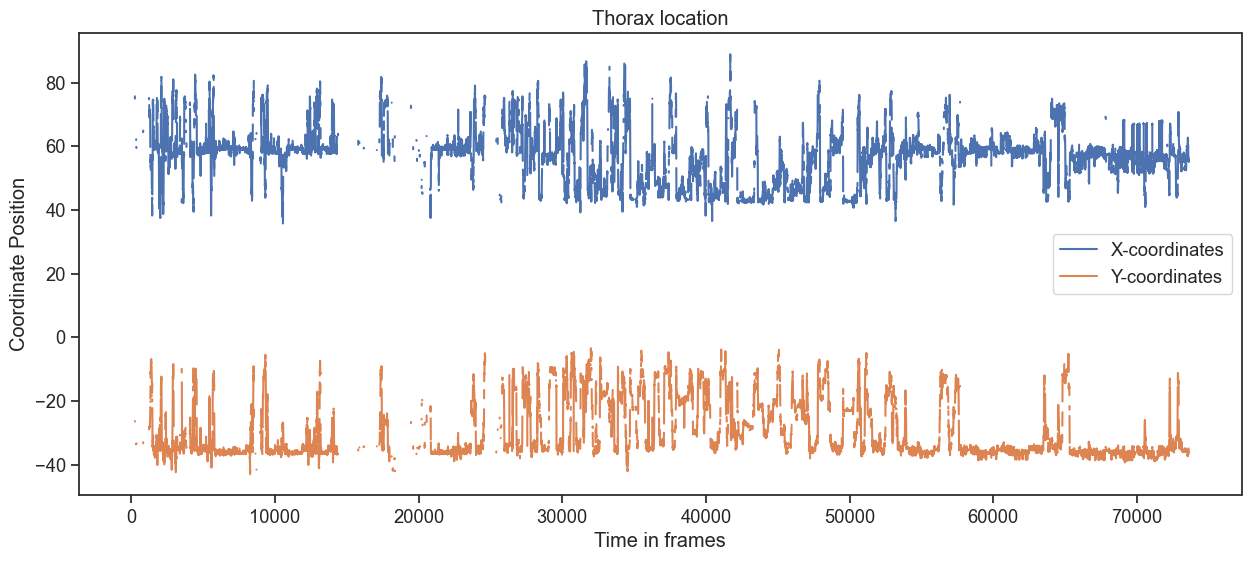

In [76]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax location')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

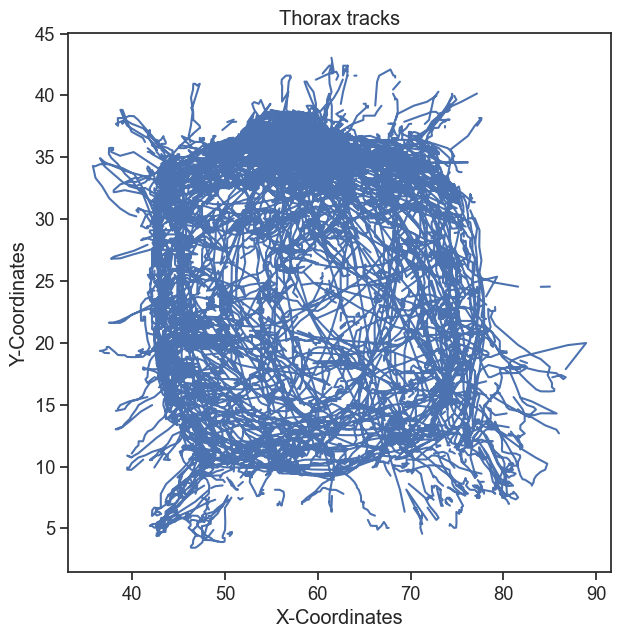

In [77]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


In [78]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"].iloc[0].shape

(73601, 6, 2)

In [79]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"].apply(lambda x: fill_missing(x))
VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_agent_location_all-frames_rescaled"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_agent_location_all-frames_rescaled"].apply(lambda x: fill_missing(x) if x is not np.nan else np.nan)

In [80]:
location = VIDEO_TO_FRAME_AND_SUBJECT_DF["full-recording_subject_location_all-frames_rescaled"].iloc[FILE_INDEX]


In [81]:
thorax_loc = location[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

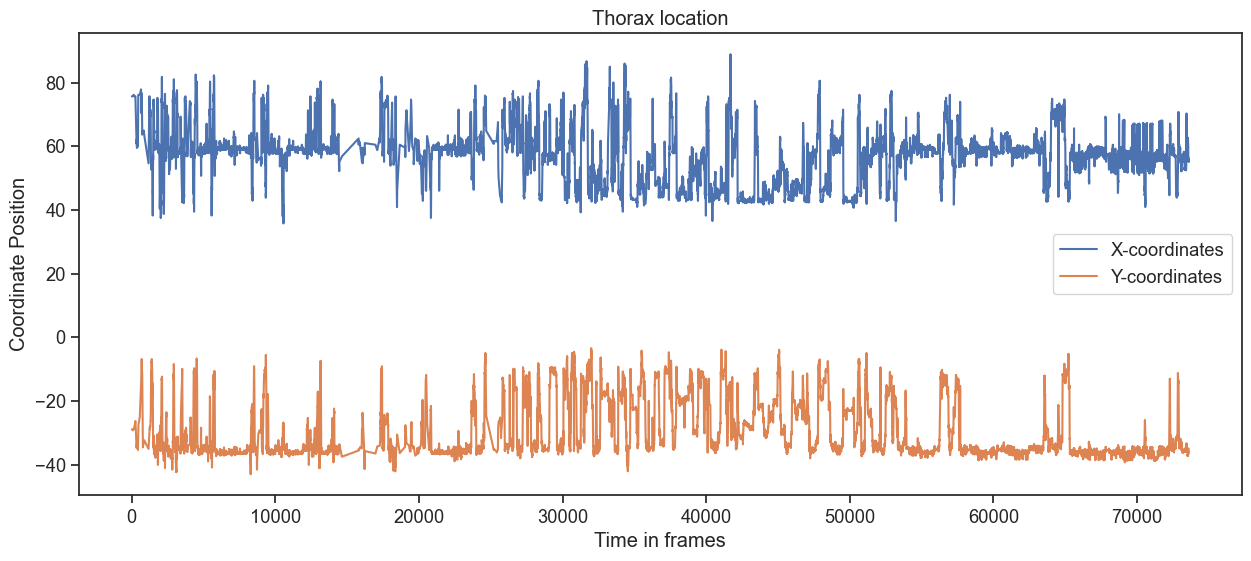

In [82]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax location')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

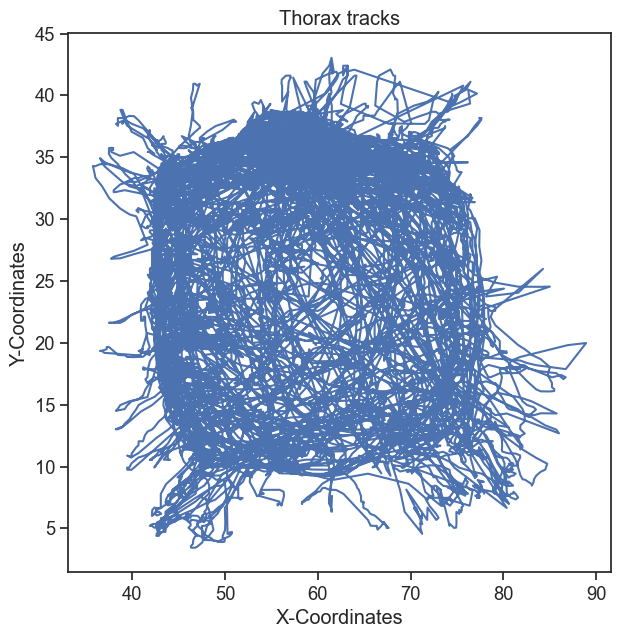

In [83]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


# Creating a histogram of all the velocities for each trial type

In [84]:
TONE_TIMESTAMP_DF["current_subject"] = TONE_TIMESTAMP_DF["current_subject"].astype(str)

In [85]:
TONE_TIMESTAMP_DF["video_name"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_and_6_2.1',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1.1',
       '20221214_125409_om_and_comp_6_1_and_6_3.1',
       '20221215_145401_comp_amd_om_6_1_and_6_3.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.1',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.2',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.2'],
      dtype=object)

In [86]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["video_name"].unique()

array(['20221214_125409_om_and_comp_6_1_and_6_3.1',
       '20221215_145401_comp_amd_om_6_1_and_6_3.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.1',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2.3',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.3',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4.4',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.1',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.2',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.1',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.2'],
      dtype=object)

In [87]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,video_name,recording_name,all_sleap_data,location,track_names,...,average_width,width_ratio,height_ratio,full-recording_subject_location_all-frames_rescaled,full-recording_agent_location_all-frames_rescaled,box_bottom_left,reward_port,box_top_left,box_top_right,box_bottom_right
0,/scratch/back_up/reward_competition_extention/...,1,25000,6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137] [ 719.6454467...,"[[[[1196.03015137], [719.64544678]], [[nan], [...",[6.3],...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...",NaN,"[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
1,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]",...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...","[[[57.83703009132662, 36.09667974811658], [75....","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
2,/scratch/back_up/reward_competition_extention/...,27500,73601,6.1_6.3,6.1_6.3,20221214_125409_om_and_comp_6_1_and_6_3.1,20221214_125409_om_and_comp_6_1_and_6_3,{'location': [[[[1196.03015137 nan] ...,"[[[[1196.03015137 nan], [719.6454467...","[6.1, 6.3]",...,481.751716,0.061235,0.040623,"[[[57.83703009132662, 36.09667974811658], [75....","[[[73.23874162922884, 29.233888174470064], [76...","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
3,/scratch/back_up/reward_competition_extention/...,51500,76455,6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576] [875.72601318]...,"[[[[987.55340576], [875.72601318]], [[960.4041...",[6.3],...,467.659204,0.063080,0.040734,"[[[62.29499004544388, 35.672226400722344], [60...",NaN,"[45.94868114383516, 34.35598589210796]","[60.745238135014795, 37.02181571211937]","[47.608511938550215, 10.898407611383128]","[77.00023667835097, 11.123249032819073]","[75.55695640403441, 35.665670752094236]"
4,/scratch/back_up/reward_competition_extention/...,1,48500,6.1_6.3,6.1_6.3,20221215_145401_comp_amd_om_6_1_and_6_3.1,20221215_145401_comp_amd_om_6_1_and_6_3,{'location': [[[[987.55340576 nan ...,[[[[987.55340576 nan nan ...,"[6.1, 6.3, track_646, track_647, track_1507, t...",...,467.659204,0.063080,0.040734,"[[[62.29499004544388, 35.672226400722344], [60...","[[[46.912688050019156, 25.74061605165152], [42...","[45.94868114383516, 34.35598589210796]","[60.745238135014795, 37.02181571211937]","[47.608511938550215, 10.898407611383128]","[77.00023667835097, 11.123249032819073]","[75.55695640403441, 35.665670752094236]"


In [88]:
TONE_TIMESTAMP_DF[TONE_TIMESTAMP_DF["recording_file"] == "20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3"]["video_frame"]

66     1405
67     3002
68     4798
69     6395
70     7892
71     9889
72    11785
73    13582
74    15179
75    16975
76    18972
77    20768
78    23164
79    24961
80    28574
81    30569
82    32813
83    34807
84    36677
85    39170
86    41538
87    43782
88    45777
89    48020
90    50514
91    52757
92    55749
93    57993
94    60112
95    62355
96    64724
97    67716
98    69710
Name: video_frame, dtype: int64

In [89]:
TONE_TIMESTAMP_DF

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,trial_ephys_timestamp_range,baseline_videoframe_range,trial_videoframe_range,trial_number,Cohort,spike_interface_mPFC,spike_interface_vHPC,spike_interface_BLA,spike_interface_LH,spike_interface_MD
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"(1390826, 1590826)","(1514, 1734)","(1734, 1954)",1,1,21.0,15.0,14.0,13.0,16.0
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"(2990825, 3190825)","(3508, 3728)","(3728, 3948)",2,1,21.0,15.0,14.0,13.0,16.0
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"(4790823, 4990823)","(5752, 5972)","(5972, 6192)",3,1,21.0,15.0,14.0,13.0,16.0
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"(6390821, 6590821)","(7746, 7966)","(7966, 8186)",4,1,21.0,15.0,14.0,13.0,16.0
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"(7890820, 8090820)","(9616, 9836)","(9836, 10056)",5,1,21.0,15.0,14.0,13.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,65281838,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,62088794,20230621_111240_standard_comp_to_omission_D5_s...,61972,2.0,1-4_t3b3L_box1,rewarded,20230621_111240_standard_comp_to_omission_D5_s...,...,"(62088794, 62288794)","(61752, 61972)","(61972, 62192)",36,2,15.0,31.0,30.0,29.0,28.0
579,66781856,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,63588812,20230621_111240_standard_comp_to_omission_D5_s...,63469,2.0,1-4_t3b3L_box1,rewarded,20230621_111240_standard_comp_to_omission_D5_s...,...,"(63588812, 63788812)","(63249, 63469)","(63469, 63689)",37,2,15.0,31.0,30.0,29.0,28.0
580,68781880,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,65588836,20230621_111240_standard_comp_to_omission_D5_s...,65465,2.0,1-4_t3b3L_box1,rewarded,20230621_111240_standard_comp_to_omission_D5_s...,...,"(65588836, 65788836)","(65245, 65465)","(65465, 65685)",38,2,15.0,31.0,30.0,29.0,28.0
581,70681909,20230621_111240_standard_comp_to_omission_D5_s...,20230621_111240_standard_comp_to_omission_D5_s...,67488865,20230621_111240_standard_comp_to_omission_D5_s...,67362,2.0,1-4_t3b3L_box1,omission,20230621_111240_standard_comp_to_omission_D5_s...,...,"(67488865, 67688865)","(67142, 67362)","(67362, 67582)",39,2,15.0,31.0,30.0,29.0,28.0


In [90]:
MERGED_TRIAL_AND_SLEAP = TONE_TIMESTAMP_DF.merge(VIDEO_TO_FRAME_AND_SUBJECT_DF, left_on=['video_name', 'current_subject'], right_on=['video_name', 'subject_id'], how="inner")


In [91]:
MERGED_TRIAL_AND_SLEAP = MERGED_TRIAL_AND_SLEAP.sort_values(by=["recording_file", "video_number", "time"]).reset_index(drop=True)

In [92]:
MERGED_TRIAL_AND_SLEAP.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name', 'all_subjects',
       'current_subject', 'trial_outcome', 'lfp_index',
       'baseline_lfp_timestamp_range', 'trial_lfp_timestamp_range',
       'baseline_ephys_timestamp_range', 'trial_ephys_timestamp_range',
       'baseline_videoframe_range', 'trial_videoframe_range', 'trial_number',
       'Cohort', 'spike_interface_mPFC', 'spike_interface_vHPC',
       'spike_interface_BLA', 'spike_interface_LH', 'spike_interface_MD',
       'file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'all_sleap_data', 'location', 'track_names',
       'subject_to_index', 'subject_and_tracks_list', 'subject_id',
       'full-recording_subject_location_all-frames_original', 'agent_id',
       'full-recording_agent_location_all-frames_original', 'corner_path',
       'corner_parts

In [93]:
MERGED_TRIAL_AND_SLEAP.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,average_width,width_ratio,height_ratio,full-recording_subject_location_all-frames_rescaled,full-recording_agent_location_all-frames_rescaled,box_bottom_left,reward_port,box_top_left,box_top_right,box_bottom_right
0,4359951,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,1408048,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,1405,1.0,6_1_top_1_base_2_vs_6_3,rewarded,20221214_125409_om_and_comp_6_1_and_6_3.1,...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...","[[[57.83703009132662, 36.09667974811658], [75....","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
1,5959954,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,3008051,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,3002,1.0,6_1_top_1_base_2_vs_6_3,rewarded,20221214_125409_om_and_comp_6_1_and_6_3.1,...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...","[[[57.83703009132662, 36.09667974811658], [75....","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
2,7759946,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,4808043,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,4798,1.0,6_1_top_1_base_2_vs_6_3,rewarded,20221214_125409_om_and_comp_6_1_and_6_3.1,...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...","[[[57.83703009132662, 36.09667974811658], [75....","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
3,9359945,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,6408042,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,6395,1.0,6_1_top_1_base_2_vs_6_3,omission,20221214_125409_om_and_comp_6_1_and_6_3.1,...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...","[[[57.83703009132662, 36.09667974811658], [75....","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"
4,10859943,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,7908040,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,7892,1.0,6_1_top_1_base_2_vs_6_3,rewarded,20221214_125409_om_and_comp_6_1_and_6_3.1,...,481.751716,0.061235,0.040623,"[[[73.23874162922884, 29.233888174470064], [76...","[[[57.83703009132662, 36.09667974811658], [75....","[44.003285298963824, 34.44102787460576]","[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]"


In [94]:
MERGED_TRIAL_AND_SLEAP["subject_id"]

0      6.1
1      6.1
2      6.1
3      6.1
4      6.1
      ... 
533    1.4
534    1.4
535    1.4
536    1.4
537    1.4
Name: subject_id, Length: 538, dtype: object

In [95]:
MERGED_TRIAL_AND_SLEAP["current_subject"]

0      6.1
1      6.1
2      6.1
3      6.1
4      6.1
      ... 
533    1.4
534    1.4
535    1.4
536    1.4
537    1.4
Name: current_subject, Length: 538, dtype: object

In [96]:
MERGED_TRIAL_AND_SLEAP["video_frame"]

0       1405
1       3002
2       4798
3       6395
4       7892
       ...  
533    65550
534    67447
535    67447
536    68444
537    68444
Name: video_frame, Length: 538, dtype: int64

In [97]:
MERGED_TRIAL_AND_SLEAP["full-recording_subject_location_all-frames_rescaled"].iloc[0].shape

(73601, 6, 2)

- Filtering for all the trial video combinations where the subject is in the given trial

In [98]:
MERGED_TRIAL_AND_SLEAP["start_frame"].head()

0    27500
1    27500
2    27500
3    27500
4    27500
Name: start_frame, dtype: int64

In [99]:
MERGED_TRIAL_AND_SLEAP["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [100]:
MERGED_TRIAL_AND_SLEAP = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["video_frame"] >= MERGED_TRIAL_AND_SLEAP['start_frame']) & (MERGED_TRIAL_AND_SLEAP["video_frame"] <= MERGED_TRIAL_AND_SLEAP['stop_frame'])].reset_index(drop=True)

In [101]:
MERGED_TRIAL_AND_SLEAP["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

- Getting the time stampes of each 1 sec segment

In [102]:
calculate_all_window_indices(200, 100, 50, 200) 
                             # SPIKEGADGETS_SAMPLE_RATE, SPIKEGADGETS_SAMPLE_RATE//2, SPIKEGADGETS_SAMPLE_RATE*TRIAL_DURATION)

[(200, 300), (250, 350), (300, 400)]

In [103]:
SPIKEGADGETS_SAMPLE_RATE

20000

In [104]:
MERGED_TRIAL_AND_SLEAP["chunked_trial_ephys_timestamp"] = MERGED_TRIAL_AND_SLEAP["time_stamp_index"].apply(lambda x: calculate_all_window_indices(x, SPIKEGADGETS_SAMPLE_RATE, SPIKEGADGETS_SAMPLE_RATE//2, SPIKEGADGETS_SAMPLE_RATE*TRIAL_DURATION))

In [105]:
MERGED_TRIAL_AND_SLEAP["chunked_baseline_ephys_timestamp"] = MERGED_TRIAL_AND_SLEAP["time_stamp_index"].apply(lambda x: calculate_all_window_indices(x-SPIKEGADGETS_SAMPLE_RATE*TRIAL_DURATION, SPIKEGADGETS_SAMPLE_RATE, SPIKEGADGETS_SAMPLE_RATE//2, SPIKEGADGETS_SAMPLE_RATE*TRIAL_DURATION))

In [106]:
MERGED_TRIAL_AND_SLEAP["chunked_trial_lfp_index"] = MERGED_TRIAL_AND_SLEAP["lfp_index"].apply(lambda x: calculate_all_window_indices(x, LFP_SAMPLE_RATE, LFP_SAMPLE_RATE//2, LFP_SAMPLE_RATE*TRIAL_DURATION))

In [107]:
MERGED_TRIAL_AND_SLEAP["chunked_baseline_lfp_index"] = MERGED_TRIAL_AND_SLEAP["lfp_index"].apply(lambda x: calculate_all_window_indices(x-LFP_SAMPLE_RATE*TRIAL_DURATION, LFP_SAMPLE_RATE, LFP_SAMPLE_RATE//2, LFP_SAMPLE_RATE*TRIAL_DURATION))

In [108]:
MERGED_TRIAL_AND_SLEAP["chunked_baseline_ephys_timestamp"].iloc[0]

[(27798597, 27818597),
 (27808597, 27828597),
 (27818597, 27838597),
 (27828597, 27848597),
 (27838597, 27858597),
 (27848597, 27868597),
 (27858597, 27878597),
 (27868597, 27888597),
 (27878597, 27898597),
 (27888597, 27908597),
 (27898597, 27918597),
 (27908597, 27928597),
 (27918597, 27938597),
 (27928597, 27948597),
 (27938597, 27958597),
 (27948597, 27968597),
 (27958597, 27978597),
 (27968597, 27988597),
 (27978597, 27998597)]

In [109]:
MERGED_TRIAL_AND_SLEAP["chunked_trial_ephys_timestamp"].iloc[0]

[(27998597, 28018597),
 (28008597, 28028597),
 (28018597, 28038597),
 (28028597, 28048597),
 (28038597, 28058597),
 (28048597, 28068597),
 (28058597, 28078597),
 (28068597, 28088597),
 (28078597, 28098597),
 (28088597, 28108597),
 (28098597, 28118597),
 (28108597, 28128597),
 (28118597, 28138597),
 (28128597, 28148597),
 (28138597, 28158597),
 (28148597, 28168597),
 (28158597, 28178597),
 (28168597, 28188597),
 (28178597, 28198597)]

In [110]:
MERGED_TRIAL_AND_SLEAP["chunked_baseline_lfp_index"].iloc[0]

[(1389929, 1390929),
 (1390429, 1391429),
 (1390929, 1391929),
 (1391429, 1392429),
 (1391929, 1392929),
 (1392429, 1393429),
 (1392929, 1393929),
 (1393429, 1394429),
 (1393929, 1394929),
 (1394429, 1395429),
 (1394929, 1395929),
 (1395429, 1396429),
 (1395929, 1396929),
 (1396429, 1397429),
 (1396929, 1397929),
 (1397429, 1398429),
 (1397929, 1398929),
 (1398429, 1399429),
 (1398929, 1399929)]

In [111]:
MERGED_TRIAL_AND_SLEAP["chunked_trial_lfp_index"].iloc[0]

[(1399929, 1400929),
 (1400429, 1401429),
 (1400929, 1401929),
 (1401429, 1402429),
 (1401929, 1402929),
 (1402429, 1403429),
 (1402929, 1403929),
 (1403429, 1404429),
 (1403929, 1404929),
 (1404429, 1405429),
 (1404929, 1405929),
 (1405429, 1406429),
 (1405929, 1406929),
 (1406429, 1407429),
 (1406929, 1407929),
 (1407429, 1408429),
 (1407929, 1408929),
 (1408429, 1409429),
 (1408929, 1409929)]

## Get the positions for each trial

In [112]:
MERGED_TRIAL_AND_SLEAP["full-recording_subject_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_location_all-frames_rescaled"][:, THORAX_INDEX, :], axis=1)
MERGED_TRIAL_AND_SLEAP["full-recording_agent_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_location_all-frames_rescaled"][:, THORAX_INDEX, :] if x["full-recording_agent_location_all-frames_rescaled"] is not np.nan else np.nan, axis=1)

In [113]:
MERGED_TRIAL_AND_SLEAP["full-recording_subject_thorax_location_all-frames"].iloc[0]

array([[76.64398153, 29.74038419],
       [76.64398153, 29.74038419],
       [76.62862796, 29.87797648],
       ...,
       [72.24983448, 33.29855585],
       [72.23585631, 33.15333938],
       [72.03200671, 33.00092023]])

- Smoothing out the thorax location

- Getting the location before and during the trial

In [114]:
MERGED_TRIAL_AND_SLEAP["full-recording_subject_thorax_location_all-frames"].iloc[0].shape

(73601, 2)

In [115]:
MERGED_TRIAL_AND_SLEAP.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,reward_port,box_top_left,box_top_right,box_bottom_right,chunked_trial_ephys_timestamp,chunked_baseline_ephys_timestamp,chunked_trial_lfp_index,chunked_baseline_lfp_index,full-recording_subject_thorax_location_all-frames,full-recording_agent_thorax_location_all-frames
0,30950500,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,27998597,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]","[(27998597, 28018597), (28008597, 28028597), (...","[(27798597, 27818597), (27808597, 27828597), (...","[(1399929, 1400929), (1400429, 1401429), (1400...","[(1389929, 1390929), (1390429, 1391429), (1390...","[[76.64398152506956, 29.7403841923955], [76.64...","[[75.65296644030276, 28.93393679005073], [75.6..."
1,32550496,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,29598593,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]","[(29598593, 29618593), (29608593, 29628593), (...","[(29398593, 29418593), (29408593, 29428593), (...","[(1479929, 1480929), (1480429, 1481429), (1480...","[(1469929, 1470929), (1470429, 1471429), (1470...","[[76.64398152506956, 29.7403841923955], [76.64...","[[75.65296644030276, 28.93393679005073], [75.6..."
2,34350494,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,31398591,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]","[(31398591, 31418591), (31408591, 31428591), (...","[(31198591, 31218591), (31208591, 31228591), (...","[(1569929, 1570929), (1570429, 1571429), (1570...","[(1559929, 1560929), (1560429, 1561429), (1560...","[[76.64398152506956, 29.7403841923955], [76.64...","[[75.65296644030276, 28.93393679005073], [75.6..."
3,35950496,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,32998593,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,34807,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]","[(32998593, 33018593), (33008593, 33028593), (...","[(32798593, 32818593), (32808593, 32828593), (...","[(1649929, 1650929), (1650429, 1651429), (1650...","[(1639929, 1640929), (1640429, 1641429), (1640...","[[76.64398152506956, 29.7403841923955], [76.64...","[[75.65296644030276, 28.93393679005073], [75.6..."
4,37450494,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,34498591,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,36677,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[59.051100588271076, 36.64187192940424]","[46.0507427911898, 10.897308371296559]","[74.86862664378351, 11.71692871623627]","[74.18540144637011, 36.17320921292706]","[(34498591, 34518591), (34508591, 34528591), (...","[(34298591, 34318591), (34308591, 34328591), (...","[(1724929, 1725929), (1725429, 1726429), (1725...","[(1714929, 1715929), (1715429, 1716429), (1715...","[[76.64398152506956, 29.7403841923955], [76.64.

In [116]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_thorax_location_all-frames"][x["baseline_videoframe_range"][0]:x["baseline_videoframe_range"][1]], axis=1)

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_thorax_location_all-frames"][x["baseline_videoframe_range"][0]:x["baseline_videoframe_range"][1]] if x["full-recording_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)


In [117]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_thorax_location_all-frames"][x["trial_videoframe_range"][0]:x["trial_videoframe_range"][1]], axis=1)

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_thorax_location_all-frames"][x["trial_videoframe_range"][0]:x["trial_videoframe_range"][1]] if x["full-recording_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)


In [118]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_thorax_location_all-frames"][x["baseline_videoframe_range"][0]:x["trial_videoframe_range"][1]], axis=1)

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax_location_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_thorax_location_all-frames"][x["baseline_videoframe_range"][0]:x["trial_videoframe_range"][1]] if x["full-recording_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

## Calculate Velocity

- Calculating velocity for the whole recording

In [119]:
MERGED_TRIAL_AND_SLEAP["full-recording_subject_thorax_velocity"] = MERGED_TRIAL_AND_SLEAP["full-recording_subject_thorax_location_all-frames"].apply(lambda x: compute_velocity(x, window_size=FRAME_RATE*3) * FRAME_RATE)

MERGED_TRIAL_AND_SLEAP["full-recording_agent_thorax_velocity"] = MERGED_TRIAL_AND_SLEAP["full-recording_agent_thorax_location_all-frames"].apply(lambda x: compute_velocity(x, window_size=FRAME_RATE*3) * FRAME_RATE if x is not np.nan else np.nan)

- Getting the slice of the velocity for the baseline and trial portion of the recording

In [120]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_velocity_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_thorax_velocity"][x["baseline_videoframe_range"][0]:x["baseline_videoframe_range"][1]], axis=1)

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax_velocity_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_thorax_velocity"][x["baseline_videoframe_range"][0]:x["baseline_videoframe_range"][1]] if x["full-recording_agent_thorax_velocity"] is not np.nan else np.nan, axis=1)


In [121]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_thorax_velocity"][x["trial_videoframe_range"][0]:x["trial_videoframe_range"][1]], axis=1)

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax_velocity_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_thorax_velocity"][x["trial_videoframe_range"][0]:x["trial_videoframe_range"][1]] if x["full-recording_agent_thorax_velocity"] is not np.nan else np.nan, axis=1)

In [122]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax_velocity_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_subject_thorax_velocity"][x["baseline_videoframe_range"][0]:x["trial_videoframe_range"][1]], axis=1)

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax_velocity_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda x: x["full-recording_agent_thorax_velocity"][x["baseline_videoframe_range"][0]:x["trial_videoframe_range"][1]] if x["full-recording_agent_thorax_velocity"] is not np.nan else np.nan, axis=1)

- Getting the average velocity of each 1 sec segment

In [123]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_velocity_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_velocity_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)))

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax_velocity_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax_velocity_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

In [124]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_chunked"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)))

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax_velocity_chunked"] = MERGED_TRIAL_AND_SLEAP["trial_agent_thorax_velocity_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

In [125]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax_velocity_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax_velocity_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)))

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax_velocity_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax_velocity_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

- Grouping each chunk by range

In [126]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_velocity_binned"] = MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_velocity_chunked"].apply(lambda x: np.array([np.digitize(num, VELOCITY_BINS) for num in x]))

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax_velocity_binned"] = MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax_velocity_chunked"].apply(lambda x: np.array([np.digitize(num, VELOCITY_BINS) for num in x]) if x is not np.nan else np.nan)

In [127]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_binned"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_chunked"].apply(lambda x: np.array([np.digitize(num, VELOCITY_BINS) for num in x]))

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax_velocity_binned"] = MERGED_TRIAL_AND_SLEAP["trial_agent_thorax_velocity_chunked"].apply(lambda x: np.array([np.digitize(num, VELOCITY_BINS) for num in x]) if x is not np.nan else np.nan)

In [128]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax_velocity_binned"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax_velocity_chunked"].apply(lambda x: np.array([np.digitize(num, VELOCITY_BINS) for num in x]))

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax_velocity_binned"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax_velocity_chunked"].apply(lambda x: np.array([np.digitize(num, VELOCITY_BINS) for num in x]) if x is not np.nan else np.nan)

In [129]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_binned"].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: trial_subject_thorax_velocity_binned, dtype: object

- Seeing how many windows of each bin

In [130]:
flat_list = [item for sublist in MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax_velocity_binned"] for item in sublist]


In [131]:
Counter(flat_list)

Counter({0: 3693, 1: 889, 2: 493, 3: 207})

In [132]:
flat_list = [item for sublist in MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_binned"] for item in sublist]


In [133]:
Counter(flat_list)

Counter({0: 4010, 1: 742, 2: 378, 3: 152})

In [134]:
MERGED_TRIAL_AND_SLEAP["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

# Creating a histogram of all the velocities for each trial type

In [135]:
num_lines = 3

In [136]:
# Generate colors from the "Blues" colormap
losing_colors = cm.Oranges(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
winning_colors = cm.Blues(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
rewarded_colors = cm.Greens(np.linspace(0.5, 1, num_lines))
# Generate colors from the "Blues" colormap
omission_colors = cm.Reds(np.linspace(0.5, 1, num_lines))

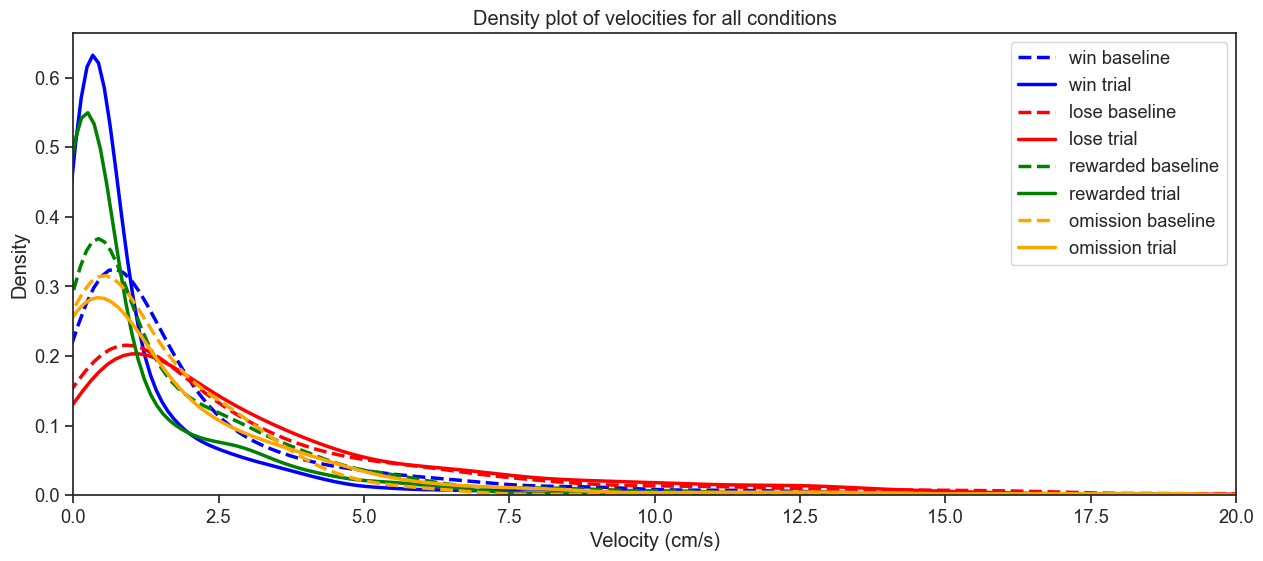

In [137]:
bin_edges = np.linspace(0, 30, 30)  # 30 bins, for example
fig, ax = plt.subplots()

for outcome in MERGED_TRIAL_AND_SLEAP["trial_outcome"].unique():
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]
    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['baseline_subject_thorax_velocity_chunked'] for item in sublist]
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "baseline"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["baseline"])

    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['trial_subject_thorax_velocity_chunked'] for item in sublist]
    
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "trial"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["trial"])


plt.legend()
plt.title('Density plot of velocities for all conditions'.format(outcome))
plt.xlabel('Velocity (cm/s)')
plt.ylabel('Density')
plt.xlim(0,20)
plt.savefig("./proc/all_outcome_velocity_kde.png")
plt.show()

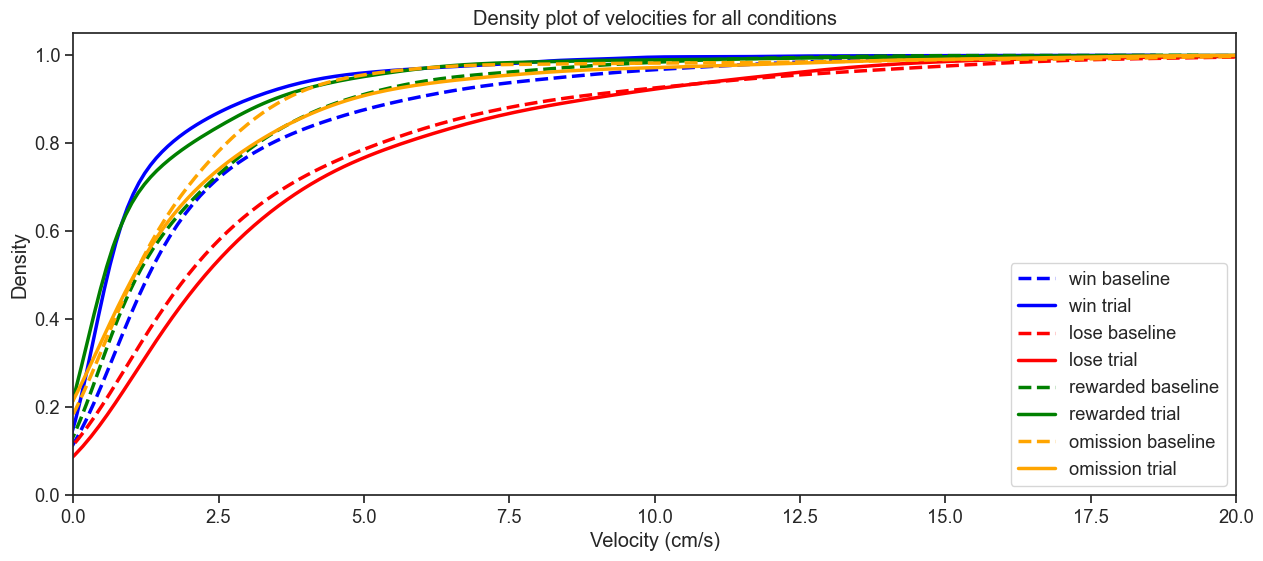

In [138]:
bin_edges = np.linspace(0, 30, 30)  # 30 bins, for example
fig, ax = plt.subplots()

for outcome in MERGED_TRIAL_AND_SLEAP["trial_outcome"].unique():
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]
    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['baseline_subject_thorax_velocity_chunked'] for item in sublist]
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "baseline"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["baseline"], cumulative=True)

    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['trial_subject_thorax_velocity_chunked'] for item in sublist]
    
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "trial"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["trial"], cumulative=True)


plt.legend()
plt.title('Density plot of velocities for all conditions'.format(outcome))
plt.xlabel('Velocity (cm/s)')
plt.ylabel('Density')
plt.xlim(0,20)
plt.savefig("./proc/all_outcome_velocity_kde.png")
plt.show()

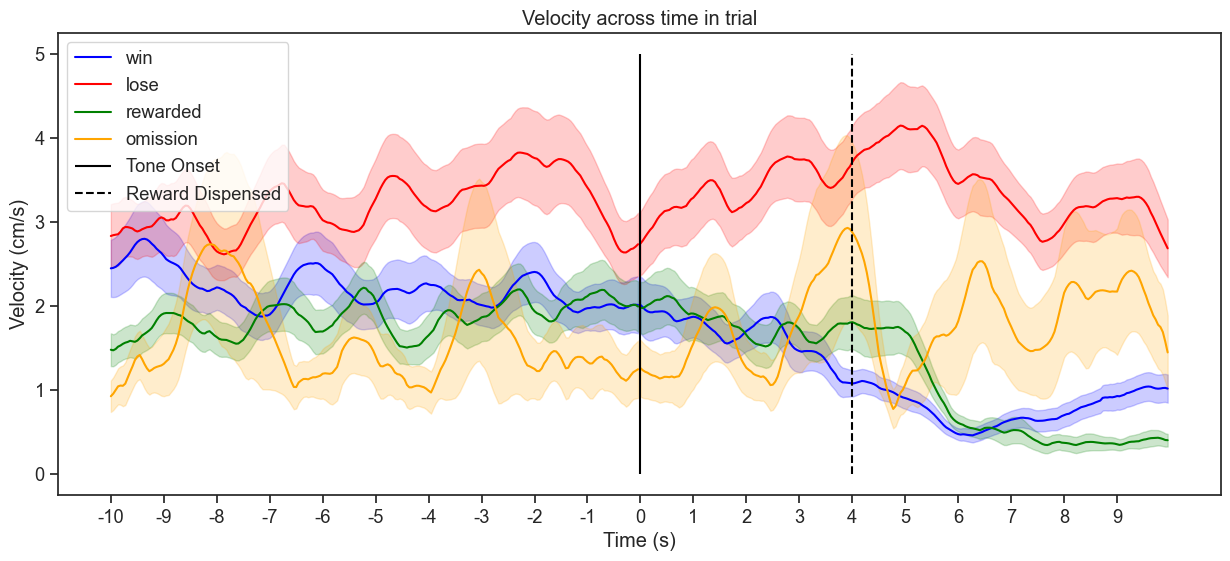

In [139]:
fig, ax = plt.subplots()

for outcome in MERGED_TRIAL_AND_SLEAP["trial_outcome"].unique():
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['trial_subject_thorax_velocity_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(len(mean)), mean, label=outcome, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['baseline_subject_thorax_velocity_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(-len(mean), 0), mean, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

# Making new ticks that are divisible by 10
x_ticks_range = np.arange(-len(mean), len(mean), FRAME_RATE)
plt.xticks(x_ticks_range)
# Converting the x ticks into seconds
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [str(int(label.replace('−', '-')) // FRAME_RATE)  for label in labels]
ax.set_xticklabels(new_labels)
plt.vlines(x=0*FRAME_RATE, ymin=0, ymax=5, label="Tone Onset", colors="black")
plt.vlines(x=4*FRAME_RATE, ymin=0, ymax=5, label="Reward Dispensed", colors="black", linestyles="--")


plt.title("Velocity across time in trial")
plt.xlabel("Time (s)")
plt.ylabel('Velocity (cm/s)')

plt.legend(loc="upper left")
plt.savefig("./proc/all_outcome_velocity_across_trial.png")
plt.show()

In [140]:
MERGED_TRIAL_AND_SLEAP["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)

In [141]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_chunked"]

0      [0.49872187702582166, 0.5847505450273386, 1.07...
1      [0.3129891797005337, 0.2588847730730972, 0.210...
2      [0.19868857983610794, 0.508612732615851, 0.481...
3      [0.4673908122355257, 0.39056964369789443, 0.38...
4      [0.23449342689004346, 0.17815867178863123, 0.2...
                             ...                        
273    [2.8673749114549376, 2.1051248595972853, 2.746...
274    [4.4337450746944, 4.929890896240105, 3.0717645...
275    [3.6437775596617503, 3.420233732721458, 5.7684...
276    [3.272800272388251, 2.9240571201096928, 2.3976...
277    [2.5610407629709404, 1.7633680887686187, 2.356...
Name: trial_subject_thorax_velocity_chunked, Length: 278, dtype: object

- Calculating the mean velocity for each velocity bin

In [142]:
MERGED_TRIAL_AND_SLEAP["0_to_2-5_cm-s_velocity"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_all-frames"].apply(lambda x: np.array([velocity for velocity in x if 0 <= velocity <= 2.5]).mean())

In [143]:
MERGED_TRIAL_AND_SLEAP.groupby("trial_outcome")["0_to_2-5_cm-s_velocity"].mean()

trial_outcome
lose        1.050260
omission    0.775549
rewarded    0.510890
win         0.589470
Name: 0_to_2-5_cm-s_velocity, dtype: float64

In [144]:
MERGED_TRIAL_AND_SLEAP.groupby("trial_outcome")["0_to_2-5_cm-s_velocity"].sem()

trial_outcome
lose        0.035791
omission    0.136630
rewarded    0.037445
win         0.029589
Name: 0_to_2-5_cm-s_velocity, dtype: float64

In [145]:
MERGED_TRIAL_AND_SLEAP["2-5_5cm-s_velocity"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_all-frames"].apply(lambda x: np.array([velocity for velocity in x if 2.5 <= velocity <= 5]).mean())

/tmp/ipykernel_3375328/1888238330.py:1: RuntimeWarning: Mean of empty slice.
  MERGED_TRIAL_AND_SLEAP["2-5_5cm-s_velocity"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_all-frames"].apply(lambda x: np.array([velocity for velocity in x if 2.5 <= velocity <= 5]).mean())
/home/riwata/miniconda3/envs/spike_interface_0_99_0/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [146]:
MERGED_TRIAL_AND_SLEAP.groupby("trial_outcome")["2-5_5cm-s_velocity"].mean()

trial_outcome
lose        3.508450
omission    3.590835
rewarded    3.558821
win         3.485267
Name: 2-5_5cm-s_velocity, dtype: float64

In [147]:
MERGED_TRIAL_AND_SLEAP.groupby("trial_outcome")["2-5_5cm-s_velocity"].sem()

trial_outcome
lose        0.035193
omission    0.055297
rewarded    0.035281
win         0.051538
Name: 2-5_5cm-s_velocity, dtype: float64

In [148]:
MERGED_TRIAL_AND_SLEAP["0_to_2-5_cm-s_velocity"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax_velocity_all-frames"].apply(lambda x: np.array([velocity for velocity in x if 0 <= velocity <= 2.5]))

In [149]:
MERGED_TRIAL_AND_SLEAP["0_to_2-5_cm-s_velocity"]

0      [0.18170472850681613, 0.16961378983662276, 0.2...
1      [0.38577700470932025, 0.16352840888997497, 0.0...
2      [0.16560567036540477, 0.1278165569746918, 0.09...
3      [0.6307901161394641, 0.6655381193431421, 0.701...
4      [0.15955796441347841, 0.18843088608181321, 0.2...
                             ...                        
273    [2.1120188926185564, 1.6393039932415667, 1.194...
274    [1.49028833044856, 1.5078417559228794, 1.68932...
275    [2.0892218715089443, 1.6078504061708718, 1.083...
276    [2.447825910373833, 2.3383201769646784, 2.2655...
277    [1.892596794063099, 2.290202972181917, 2.23838...
Name: 0_to_2-5_cm-s_velocity, Length: 278, dtype: object

In [150]:
MERGED_TRIAL_AND_SLEAP.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,baseline-trial_subject_thorax_velocity_chunked,baseline-trial_agent_thorax_velocity_chunked,baseline_subject_thorax_velocity_binned,baseline_agent_thorax_velocity_binned,trial_subject_thorax_velocity_binned,trial_agent_thorax_velocity_binned,baseline-trial_subject_thorax_velocity_binned,baseline-trial_agent_thorax_velocity_binned,0_to_2-5_cm-s_velocity,2-5_5cm-s_velocity
0,30950500,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,27998597,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,28574,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[1.6838472335457935, 1.7550373254126983, 1.372...","[15.351293593757395, 17.38503629049629, 10.908...","[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, ...","[3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...","[2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, ...","[3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0.18170472850681613, 0.16961378983662276, 0.2...",3.645197
1,32550496,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,29598593,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,30569,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[1.458421075097482, 0.5407183310858753, 0.2360...","[7.745760028782926, 6.013816566508919, 4.00063...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, ...","[2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, ...","[2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, ...","[0.38577700470932025, 0.16352840888997497, 0.0...",NaN
2,34350494,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,31398591,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,32813,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[3.439626522203859, 1.5683251160952123, 1.1535...","[11.831466040769156, 19.42405129848244, 17.084...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 3, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 3, 2, 0, 1, 1, 2, 2, 2, 2, 1, 0, 0, 0, ...","[0.16560567036540477, 0.1278165569746918, 0.09...",NaN
3,35950496,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,32998593,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,34807,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[0.900289992310536, 0.3533926495729531, 0.2807...","[2.2193795344823624, 1.735850905207599, 2.9155...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 2, ...","[0.6307901161394641, 0.6655381193431421, 0.701...",NaN
4,37450494,20221214_125409_om_and_comp_6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,34498591,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,36677,1.0,6_1_top_1_base_2_vs_6_3,win_non_comp,20221214_125409_om_and_comp_6_1_and_6_3.1,...,"[0.3903027043299651, 0.397100110767035, 0.8705...","[2.603933135747843, 1.291394992138426, 1.42710...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0

# Calculating the distance from thorax of subject or agent to reward port

- Distance from subject or agent to reward port

In [151]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-reward-port_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["trial_subject_thorax_location_all-frames"] - row["reward_port"], axis=1), axis=1)

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax-to-reward-port_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["trial_agent_thorax_location_all-frames"] - row["reward_port"], axis=1) if row["trial_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

In [152]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["baseline_subject_thorax_location_all-frames"] - row["reward_port"], axis=1), axis=1)

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax-to-reward-port_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["baseline_agent_thorax_location_all-frames"] - row["reward_port"], axis=1) if row["baseline_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

In [153]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-reward-port_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["baseline-trial_subject_thorax_location_all-frames"] - row["reward_port"], axis=1), axis=1)

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax-to-reward-port_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["baseline-trial_agent_thorax_location_all-frames"] - row["reward_port"], axis=1) if row["trial_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

- Getting the average distance for each window

In [154]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-reward-port_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-reward-port_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)))

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax-to-reward-port_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["trial_agent_thorax-to-reward-port_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

In [155]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)))

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax-to-reward-port_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax-to-reward-port_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

In [156]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-reward-port_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-reward-port_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)))

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax-to-reward-port_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax-to-reward-port_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

- Grouping each window by distance range

In [157]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-reward-port_distance_binned"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-reward-port_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]))

MERGED_TRIAL_AND_SLEAP["trial_agent_thorax-to-reward-port_distance_binned"] = MERGED_TRIAL_AND_SLEAP["trial_agent_thorax-to-reward-port_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

In [158]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_binned"] = MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-reward-port_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]))

MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax-to-reward-port_distance_binned"] = MERGED_TRIAL_AND_SLEAP["baseline_agent_thorax-to-reward-port_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

In [159]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-reward-port_distance_binned"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-reward-port_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]))

MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax-to-reward-port_distance_binned"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_agent_thorax-to-reward-port_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

## Calculating the distance from subject to agent

- Calculating the distance for every frame

In [160]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-agent_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["baseline_agent_thorax_location_all-frames"] - row["baseline_subject_thorax_location_all-frames"], axis=1) if row["baseline_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

In [161]:
MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-agent_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["trial_agent_thorax_location_all-frames"] - row["trial_subject_thorax_location_all-frames"], axis=1) if row["trial_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

In [162]:
MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-agent_distance_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: np.linalg.norm(row["baseline-trial_agent_thorax_location_all-frames"] - row["baseline-trial_subject_thorax_location_all-frames"], axis=1) if row["baseline-trial_agent_thorax_location_all-frames"] is not np.nan else np.nan, axis=1)

- Getting the average velocity of each 1 sec segment

In [163]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-agent_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-agent_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-agent_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-agent_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-agent_distance_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-agent_distance_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

- Grouping each window by distance range

In [164]:
MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-agent_distance_binned"] = MERGED_TRIAL_AND_SLEAP["baseline_subject_thorax-to-agent_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-agent_distance_binned"] = MERGED_TRIAL_AND_SLEAP["trial_subject_thorax-to-agent_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-agent_distance_binned"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject_thorax-to-agent_distance_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

## Calculating the ratio of subject to reward port vs agent to reward port

- Calculating the ratio 

In [165]:
MERGED_TRIAL_AND_SLEAP["baseline_subject-agent_to-reward-port-distance-ratio_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: row["baseline_subject_thorax-to-reward-port_distance_all-frames"] / row["baseline_agent_thorax-to-reward-port_distance_all-frames"] if row["baseline_agent_thorax-to-reward-port_distance_all-frames"] is not np.nan else np.nan, axis=1)

MERGED_TRIAL_AND_SLEAP["trial_subject-agent_to-reward-port-distance-ratio_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: row["trial_subject_thorax-to-reward-port_distance_all-frames"] / row["trial_agent_thorax-to-reward-port_distance_all-frames"] if row["trial_agent_thorax-to-reward-port_distance_all-frames"] is not np.nan else np.nan, axis=1)

MERGED_TRIAL_AND_SLEAP["baseline-trial_subject-agent_to-reward-port-distance-ratio_all-frames"] = MERGED_TRIAL_AND_SLEAP.apply(lambda row: row["baseline-trial_subject_thorax-to-reward-port_distance_all-frames"] / row["baseline-trial_agent_thorax-to-reward-port_distance_all-frames"] if row["baseline-trial_agent_thorax-to-reward-port_distance_all-frames"] is not np.nan else np.nan, axis=1)

In [166]:
MERGED_TRIAL_AND_SLEAP["baseline_subject-agent_to-reward-port-distance-ratio_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline_subject-agent_to-reward-port-distance-ratio_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["trial_subject-agent_to-reward-port-distance-ratio_chunked"] = MERGED_TRIAL_AND_SLEAP["trial_subject-agent_to-reward-port-distance-ratio_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["baseline-trial_subject-agent_to-reward-port-distance-ratio_chunked"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject-agent_to-reward-port-distance-ratio_all-frames"].apply(lambda x: (sliding_window_average(x, FRAME_RATE, FRAME_RATE//2)) if x is not np.nan else np.nan)




In [167]:
MERGED_TRIAL_AND_SLEAP["baseline_subject-agent_to-reward-port-distance-ratio_binned"] = MERGED_TRIAL_AND_SLEAP["baseline_subject-agent_to-reward-port-distance-ratio_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["trial_subject-agent_to-reward-port-distance-ratio_binned"] = MERGED_TRIAL_AND_SLEAP["trial_subject-agent_to-reward-port-distance-ratio_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

MERGED_TRIAL_AND_SLEAP["baseline-trial_subject-agent_to-reward-port-distance-ratio_binned"] = MERGED_TRIAL_AND_SLEAP["baseline-trial_subject-agent_to-reward-port-distance-ratio_chunked"].apply(lambda x: np.array([np.digitize(num, DISTANCE_BINS) for num in x]) if x is not np.nan else np.nan)

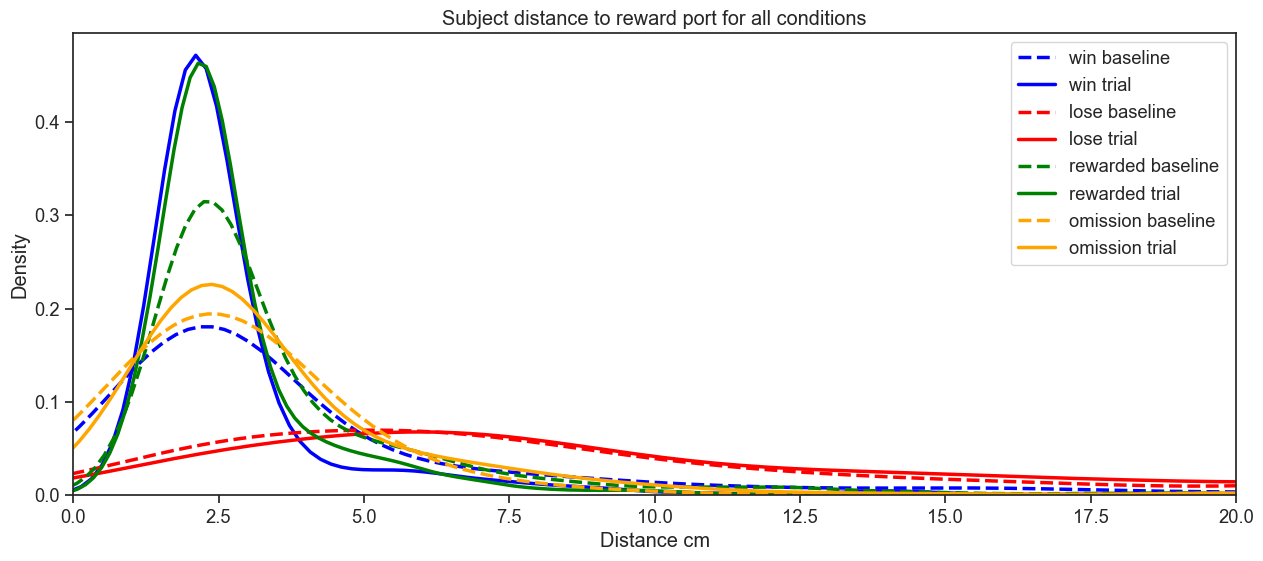

In [168]:
bin_edges = np.linspace(0, 30, 30)  # 30 bins, for example
fig, ax = plt.subplots()

for outcome in MERGED_TRIAL_AND_SLEAP["trial_outcome"].unique():
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]
    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['baseline_subject_thorax-to-reward-port_distance_chunked'] for item in sublist]
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "baseline"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["baseline"])

    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['trial_subject_thorax-to-reward-port_distance_chunked'] for item in sublist]
    
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "trial"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["trial"])


plt.legend()
plt.title('Subject distance to reward port for all conditions'.format(outcome))
plt.xlabel('Distance cm')
plt.ylabel('Density')
plt.xlim(0,20)
# plt.savefig("./proc/all_outcome_velocity_kde.png")
plt.show()

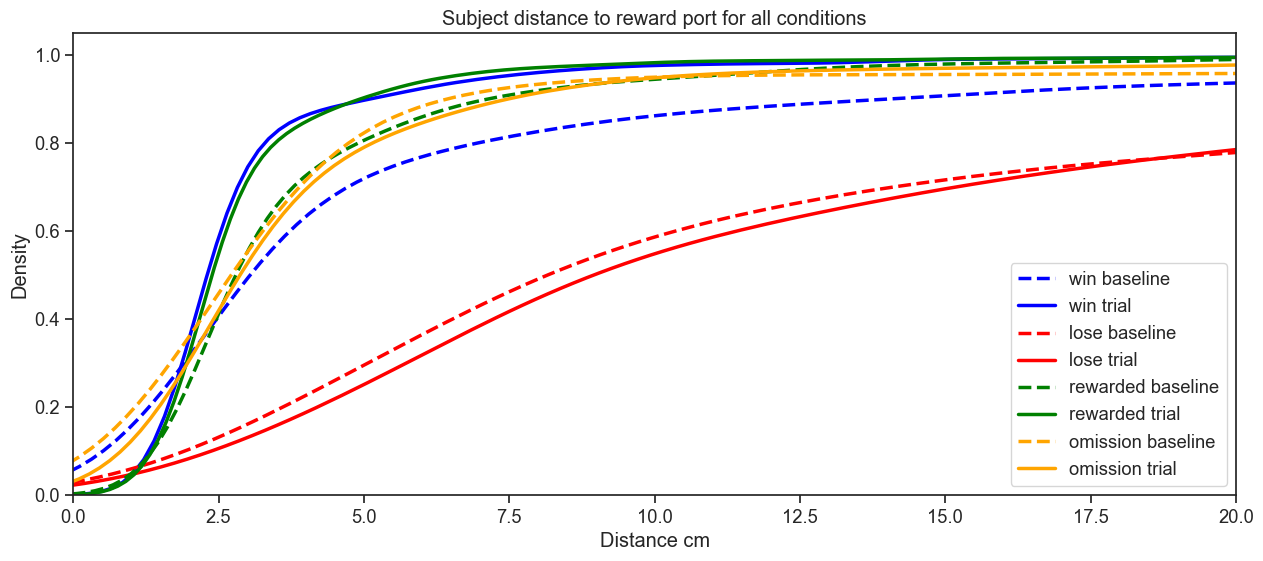

In [169]:
bin_edges = np.linspace(0, 30, 30)  # 30 bins, for example
fig, ax = plt.subplots()

for outcome in MERGED_TRIAL_AND_SLEAP["trial_outcome"].unique():
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]
    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['baseline_subject_thorax-to-reward-port_distance_chunked'] for item in sublist]
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "baseline"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["baseline"], cumulative=True)

    # Flatten the lists in the 'values' column
    flat_list = [item for sublist in current_df['trial_subject_thorax-to-reward-port_distance_chunked'] for item in sublist]
    
    sns.kdeplot(flat_list, label="{} {}".format(outcome, "trial"), color=outcome_to_color[outcome], linewidth=2.5, linestyle=trial_or_baseline_to_style["trial"], cumulative=True)


plt.legend()
plt.title('Subject distance to reward port for all conditions'.format(outcome))
plt.xlabel('Distance cm')
plt.ylabel('Density')
plt.xlim(0,20)
# plt.savefig("./proc/all_outcome_velocity_kde.png")
plt.show()

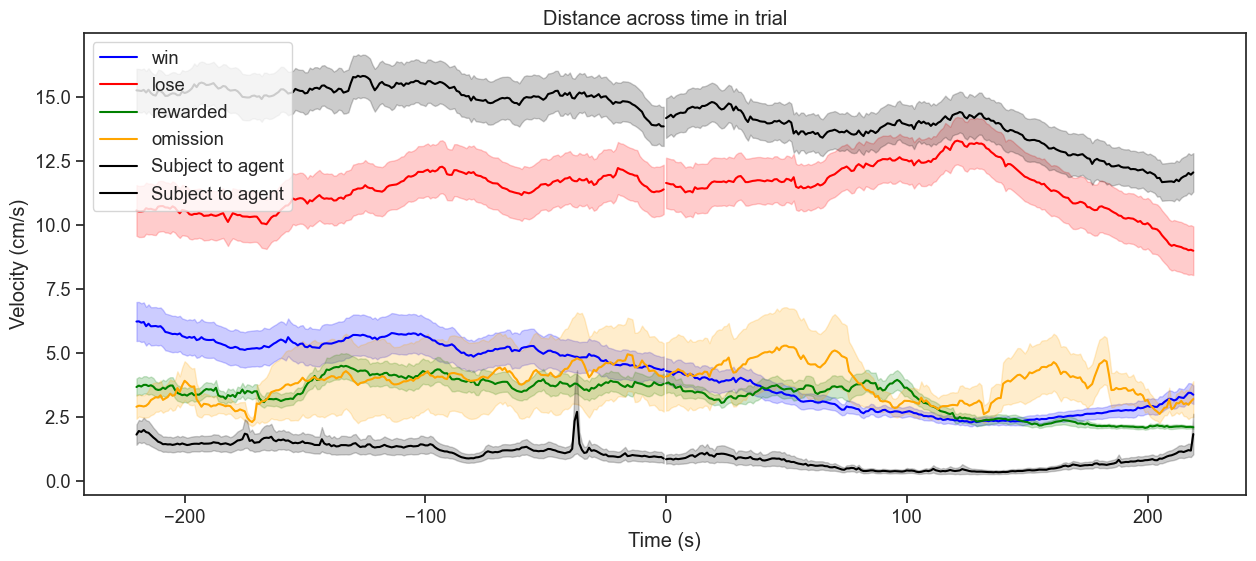

In [170]:
fig, ax = plt.subplots()

for outcome in MERGED_TRIAL_AND_SLEAP["trial_outcome"].unique():
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['trial_subject_thorax-to-reward-port_distance_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(len(mean)), mean, label=outcome, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['baseline_subject_thorax-to-reward-port_distance_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(-len(mean), 0), mean, color=outcome_to_color[outcome])
    plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color=outcome_to_color[outcome])

for outcome in ["win"]:
    current_df = MERGED_TRIAL_AND_SLEAP[(MERGED_TRIAL_AND_SLEAP["trial_outcome"] == outcome)]

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['trial_subject_thorax-to-agent_distance_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(len(mean)), mean, label="Subject to agent", color="black")
    plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color="black")

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['baseline_subject_thorax-to-agent_distance_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(-len(mean), 0), mean, color="black")
    plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color="black")

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['trial_subject-agent_to-reward-port-distance-ratio_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(len(mean)), mean, label="Subject to agent", color="black")
    plt.fill_between(np.arange(len(mean)), mean - sem, mean + sem, alpha=0.2, color="black")

    # Stack all arrays vertically
    all_arrays = np.vstack(current_df['baseline_subject-agent_to-reward-port-distance-ratio_all-frames'].values)
    mean = all_arrays.mean(axis=0) 
    # Compute the SEM for each index
    sem = all_arrays.std(axis=0) / np.sqrt(len(all_arrays))
    plt.plot(np.arange(-len(mean), 0), mean, color="black")
    plt.fill_between(np.arange(-len(mean), 0), mean - sem, mean + sem, alpha=0.2, color="black")

plt.title("Distance across time in trial")
plt.xlabel("Time (s)")
plt.ylabel('Velocity (cm/s)')

plt.legend(loc="upper left")
# plt.savefig("./proc/all_outcome_velocity_across_trial.png")
plt.show()

In [171]:
MERGED_TRIAL_AND_SLEAP["trial_outcome"]

0           win
1           win
2           win
3           win
4           win
         ...   
273    rewarded
274    rewarded
275    rewarded
276    omission
277    rewarded
Name: trial_outcome, Length: 278, dtype: object

- Dropping columns that are data of the whole recording

In [172]:
for col in MERGED_TRIAL_AND_SLEAP:
    print(col)

time
recording_dir
recording_file
time_stamp_index
video_file
video_frame
video_number
subject_info
competition_closeness
video_name
all_subjects
current_subject
trial_outcome
lfp_index
baseline_lfp_timestamp_range
trial_lfp_timestamp_range
baseline_ephys_timestamp_range
trial_ephys_timestamp_range
baseline_videoframe_range
trial_videoframe_range
trial_number
Cohort
spike_interface_mPFC
spike_interface_vHPC
spike_interface_BLA
spike_interface_LH
spike_interface_MD
file_path
start_frame
stop_frame
individual_subj
all_subj
recording_name
all_sleap_data
location
track_names
subject_to_index
subject_and_tracks_list
subject_id
full-recording_subject_location_all-frames_original
agent_id
full-recording_agent_location_all-frames_original
corner_path
corner_parts
bottom_width
top_width
right_height
left_height
average_height
average_width
width_ratio
height_ratio
full-recording_subject_location_all-frames_rescaled
full-recording_agent_location_all-frames_rescaled
box_bottom_left
reward_port
bo

In [173]:
MERGED_TRIAL_AND_SLEAP = MERGED_TRIAL_AND_SLEAP.drop(columns=[col for col in MERGED_TRIAL_AND_SLEAP if "full-recording" in col], errors="ignore")
MERGED_TRIAL_AND_SLEAP = MERGED_TRIAL_AND_SLEAP.drop(columns=[col for col in MERGED_TRIAL_AND_SLEAP if "all-frames" in col], errors="ignore")
MERGED_TRIAL_AND_SLEAP = MERGED_TRIAL_AND_SLEAP.drop(columns=["all_sleap_data", "location", "subject_to_index"], errors="ignore")

In [174]:
MERGED_TRIAL_AND_SLEAP.to_pickle("./proc/trial_SLEAP_and_metadata.pkl")

In [175]:
MERGED_TRIAL_AND_SLEAP["recording_file"].unique()

array(['20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3',
       '20221215_145401_comp_amd_om_6_1_top_4_base_3',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged'],
      dtype=object)